<a href="https://colab.research.google.com/github/jaysmehta208/Maps-For-Foodies/blob/main/Maps_For_Foodies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Removed API keys from the project. Please use your own API keys!

# **Food Truck Weekend**

In [ ]:
!pip install requests pandas
!pip install matplotlib
!pip install folium
!pip install googlemaps
!pip install gmplot

  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40713 sha256=b59501984d1078fdc3a60ca161429e11cb1e8be4bec0f68c402a9e425fdaa5d6
  Stored in directory: /root/.cache/pip/wheels/17/f8/79/999d5d37118fd35d7219ef57933eb9d09886c4c4503a800f84
Successfully built googlemaps


In [ ]:
import requests
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import folium
import googlemaps
from datetime import datetime
import gmplot

# Extraction of Data

In [ ]:
# Define API key and initial parameters
api_key = "Yelp API key"
location = "Indiana"
search_term = "food truck"
category = "foodtrucks"
results = []

offset = 0  # Initial offset
limit = 50  # Number of results per page

while True:
    # Set the offset in the search parameters
    search_params = {
        "term": search_term,
        "location": location,
        "categories": category,
        "limit": limit,
        "offset": offset
    }

    # Make the API request
    response = requests.get(
        "https://api.yelp.com/v3/businesses/search",
        params=search_params,
        headers={"Authorization": f"Bearer {api_key}"}
    )

    if response.status_code == 200:
        data = response.json()
        businesses = data.get("businesses", [])

        # Append the results to the list
        results.extend(businesses)

        # Check if there are more results to fetch
        if len(businesses) < limit:
            break
        else:
            offset += limit
    else:
        print("Error: Unable to fetch data from Yelp Fusion API")
        break

print("Successfully found all food trucks in Indiana")

Successfully found all food trucks in Indiana


The code above uses the Yelp API to find all the food trucks in Indiana

In [ ]:
# getting the ids of the businesses
business_ids = []
for business in results:
  business_ids.append(business['id'])

# stores relevant information needed like name, address, rating, website, hours of operation, cuisine, coordinates
business_details = []

# for each business id, getting all the relevant details
for business_id in business_ids:
    details_url = f"https://api.yelp.com/v3/businesses/{business_id}"
    headers = {"Authorization": f"Bearer {api_key}"}
    response = requests.get(details_url, headers=headers)

    if response.status_code == 200:
        business_data = response.json()

        # More than one cuisine could exist for each food truck
        categories = [category["title"] for category in business_data.get("categories", [])]

        # The address includes the street, city and state
        address = ", ".join(business_data["location"]["display_address"])

        # Extract latitude and longitude
        latitude = business_data["coordinates"]["latitude"]
        longitude = business_data["coordinates"]["longitude"]

        business_details.append({
            "Name": business_data["name"],
            "Address": address,
            "Rating": business_data["rating"],
            "Website": business_data.get("url"),
            "Hours": business_data.get("hours"),
            "Cuisine": ", ".join(categories),
            "Latitude": latitude,
            "Longitude": longitude
        })
    else:
        print(f"Error fetching details for business ID {business_id}")

print("Succesfully fetched all required information about each business")

Succesfully fetched all required information about each business


The above code extracts the business ids for each food truck and calls another Yelp API using these ids to get all the information required about the the food trucks. This includes Name, Address, Rating, Website, Hours, Cuisine, Latitude and Longitude.



In [ ]:
# formatting the time to see the open timings in 12 hour fromat with AM/PM
def formatHours(start, end):
  time_string = ""

  # Checking if starting time is before 12 PM or after
  if (int(start[0:2]) < 12 ):
    time_string = start[0:2] +":" + start[2:4]+ " AM - "
  elif (int(start[0:2]) >= 12 ):
    #Converting from 24 hour format to 12 hour format
    if (int(start[0:2]) >= 13):
      time_string = str(int(start[0:2]) - 12) +":" + start[2:4]+ " PM - "
    else:
      time_string = start[0:2] +":" + start[2:4]+ " PM - "

  # Checking if ending time is before 12 PM or after
  if (int(end[0:2]) < 12 ):
    time_string += end[0:2] +":" + end[2:4]+ " AM"
  elif (int(end[0:2]) >= 12 ):
    #Converting from 24 hour format to 12 hour format
    if (int(end[0:2]) >= 13):
      time_string += str(int(end[0:2]) - 12) +":" + end[2:4]+ " PM"
    else:
      time_string += end[0:2] +":" + end[2:4]+ " PM"

  return time_string

In [ ]:
# extracting the time for Saturday and Sunday and formatting it accordingly
for business in business_details:

  # If  there is data about timings on all days, but Saturday or Sunday is not present in those days, the food
  # truck is closed on that day
  saturday_hours = "Closed"
  sunday_hours = "Closed"

  # If no data about timings on any days, entry is "Null"
  if (business['Hours'] == None) :
    saturday_hours = "Null"
    sunday_hours = "Null"

  # extracting and formatting the timings on Saturday and Sunday if available
  else:
    for day in business['Hours'][0]['open']:
      if (day['day'] == 5):
        saturday_hours = formatHours(day['start'], day['end'])
      if (day['day'] == 6):
        sunday_hours = formatHours(day['start'], day['end'])

  # stroing these timings in the business details
  business['Saturday_Hours'] = saturday_hours
  business['Sunday_Hours'] = sunday_hours

  # Deleting redundant detail for each variable from list
  del business['Hours']

print("Timings for the weekend are formatted and stored")

Timings for the weekend are formatted and stored


We format the timings for Saturday and Sunday and store them in two additional elements for each food truck. "Closed" is stored as the value of the element for a particular day if it is not open on that day. If no information is provided about timings of the food truck, then the element stored is "Null".

In [ ]:
# Cleaning data
df = pd.DataFrame(business_details)

# Drop rows where "Saturday Hours" and "Sunday Hours" are "Null"
df = df[(df["Saturday_Hours"] != "Null") & (df["Sunday_Hours"] != "Null")]

# Drop columns where both "Saturday Hours" and "Sunday Hours" are "Closed"
df = df.drop(df[(df["Saturday_Hours"] == "Closed") & (df["Sunday_Hours"] == "Closed")].index, axis=0)

# Remove "Food Trucks" from each list of values and strip whitespace
df["Cuisine"] = df["Cuisine"].str.split(',')
df["Cuisine"] = df["Cuisine"].apply(lambda x: [value.strip() for value in x if "Food Trucks" not in value])

# Drop rows where there are no cuisine values left
df = df[df["Cuisine"].apply(len) > 0]

# Select main cuisine for each restaurant
df["Cuisine"] = df["Cuisine"].apply(lambda x: x[0])

# Reset the index
df = df.reset_index(drop=True)

print("Data has been cleaned")

Data has been cleaned


We convert the data into a dataframe. Then, the dataframe is cleaned by dropping all rows where open timings are "Null". Additionally, rows with food trucks closed on both days of the weekend are dropped as well. This is because we want to make a weekend-plan to visit food trucks, so those that are not open during that time do not need to be considered for the plan.

In [ ]:
# Specify the CSV file path where you want to save the DataFrame
csv_file_path = "business_details_cleaned.csv"

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)  # Use index=False to exclude the index column

print(f"DataFrame saved to {csv_file_path}")

DataFrame saved to business_details_cleaned.csv


**business_details_cleaned.csv has the required basic information**

# Exploratory Data Analysis

## Basic Statistics

In [ ]:
ratings = df['Rating']
mean = np.mean(ratings)
median = np.median(ratings)
std_dev = np.std(ratings)
print("Mean = %.2f"%mean)
print("Median =", median)
print("Standard Deviation = %.2f"% std_dev)

Mean = 4.38
Median = 4.5
Standard Deviation = 0.62


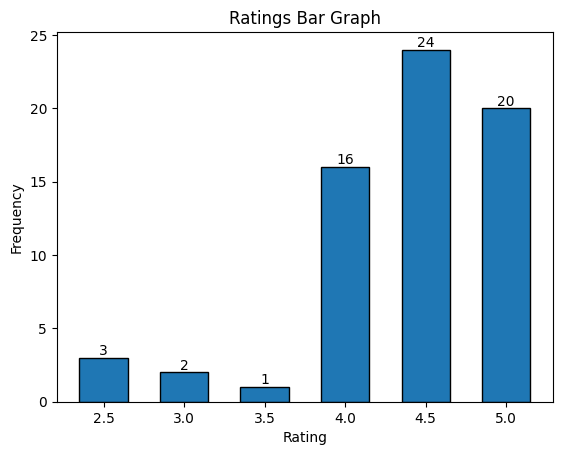

In [ ]:
# Visualising the distribution of ratings with a bar graph

# Count the frequency of each rating
rating_counts = {}
for rating in ratings:
    if rating in rating_counts:
        rating_counts[rating] += 1
    else:
        rating_counts[rating] = 1

# Sorting the ratings
ratings_list = sorted(list(rating_counts.keys()))

# Extracting the counts in the same order as the sorted ratings
counts = [rating_counts[rating] for rating in ratings_list]

# Creating a bar graph
plt.bar(ratings_list, counts, edgecolor='black', width=0.3)

# Add labels and a title
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings Bar Graph')

# Annotate each bar with its count
for rating, count in zip(ratings_list, counts):
    plt.text(rating, count, str(count), ha='center', va='bottom')

# Displaying the bar graph
plt.show()


With the median > mean, the data is only slightly skewed to the left. This means that there are not too many extremely low ratings to skew the data too much to the left. A low standard deviation indicates that most of the ratings lie around the mean and are similar. Indiana food truck customers tend to be satisfied with their experience, and rate the outlet with a rating of 4, 4.5 or 5 usually. All these conclusions are supported by the bar graph as well. As can be seen, the bars for 4, 4.5 and 5 are much longer than the ones before.The level of satisfaction cannot be completely guaged as this would require us to normalize the finding by comparing the mean rating to those of other types of restaurants. This would tell us whether customers tend to rate restaurants with ratings in 4-5 or whether food trucks just have better quality and hence are consistenly rated in 4-5.

This analysis helps us decide that we would like to stick with food trucks that are rated 4 and above (Will be done later).

## Cuisine and Rating

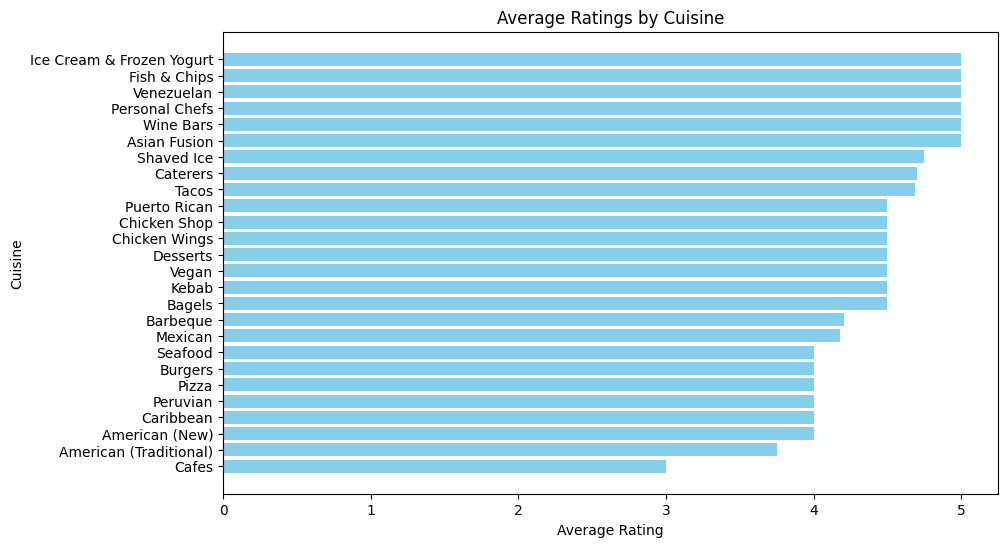

In [ ]:
# Grouping and aggregation

# Group food trucks by cuisine and compute the average rating
cuisine_ratings = df.groupby('Cuisine')['Rating'].mean().reset_index()

# Sort the cuisines by average rating in descending order
cuisine_ratings = cuisine_ratings.sort_values(by='Rating', ascending=False)

# Create a bar plot to visualize the average ratings
plt.figure(figsize=(10, 6))
plt.barh(cuisine_ratings['Cuisine'], cuisine_ratings['Rating'], color='skyblue')
plt.xlabel('Average Rating')
plt.ylabel('Cuisine')
plt.title('Average Ratings by Cuisine')
plt.gca().invert_yaxis()  # Invert the y-axis for higher ratings at the top

plt.show()


We see that the highest average rated food trucks are the ones that serve cuisines like Venezuelan and Asian Fusion. Customers also tend to rate food trucks serving American cuisine lower in comparison to other cuisines, although the ratings are quite high for these food trucks as well. Tacos, Kebabs and Mexican are some of the cuisines highly rated as well but in the middle in comparison to the two sets of cuisines we looked at before. This analysis helps us decide which cuisines to try on our weekend trip.

## Location

In [ ]:
# Calculate the average latitude and longitude
average_latitude = df['Latitude'].mean()
average_longitude = df['Longitude'].mean()

# Create a map centered at the average location
m = folium.Map(location=[average_latitude, average_longitude], zoom_start=10)

# Adding markers
for index, row in df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']]).add_to(m)

# Display the map
m.save('food_truck_map.html')  # Save the map as an HTML file
# NOTE : To open the html file, please download it, and then click on downloaded file to open in browser

The generated map: https://drive.google.com/file/d/17G3WfopgCS86XGOp0aiiYg4fQNqW_mtC/view?usp=sharing

Zoomed in view of same map: https://drive.google.com/file/d/1LcuvHnDQILVCSOo-NjlxVigIQ3KcD-7T/view?usp=sharing

The map shows us that a large number of food trucks are present around Indianapolis. There are only a few food trucks in cities like Lafayette and Bloomington.  From this map, we can conclude that to save on travel time and cost, our weekend plan should involve travelling to food trucks in the Indianapolis area.

In [ ]:
# Adding markers with name of food truck
for index, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        icon=folium.DivIcon(html=f"<div>{row['Name']}</div>")
    ).add_to(m)

# Display the map
m.save('food_truck_with_names_map.html')  # Save the map as an HTML file

I will be using this map with names of the food trucks provided to help me with my analysis.

# Planning Weekend

## Deciding final list

In [ ]:
API_KEY = "Google Maps API Kay"
gmaps = googlemaps.Client(API_KEY)

In [ ]:
# The two cities
city1 = "Indianapolis, IN"
city2 = "Carmel, IN"

# Geocoding the city names to get their coordinates
geocode_result1 = gmaps.geocode(city1)
geocode_result2 = gmaps.geocode(city2)

# Extracting latitude and longitude from the geocoding results
latitude1 = geocode_result1[0]['geometry']['location']['lat']
longitude1 = geocode_result1[0]['geometry']['location']['lng']

latitude2 = geocode_result2[0]['geometry']['location']['lat']
longitude2 = geocode_result2[0]['geometry']['location']['lng']

# Calculating the distance
result = gmaps.distance_matrix((latitude1, longitude1), (latitude2, longitude2), mode='driving', departure_time=datetime.now())
distance_in_meters = result['rows'][0]['elements'][0]['distance']['value']

# Convert the distance from meters to miles
distance_in_miles = distance_in_meters * 0.000621371

print(f"The road distance between {city1} and {city2} is approximately {distance_in_miles} miles.")

The road distance between Indianapolis, IN and Carmel, IN is approximately 16.064304463 miles.


In [ ]:
"Looking at my maps, I see that most of the food trucks are close to Indianapolis. Therefore I select a radius equal to distance from Indianapolis to Carmel BY ROAD to search for the best food trucks. This distance is around " + str(distance_in_miles) + "miles. Therefore I am making sure that my passengers do not have to travel more than " + str(3*distance_in_miles) + "miles for food between locations."

'Looking at my maps, I see that most of the food trucks are close to Indianapolis. Therefore I select a radius equal to distance from Indianapolis to Carmel BY ROAD to search for the best food trucks. This distance is around 16.064304463miles. Therefore I am making sure that my passengers do not have to travel more than 48.192913389miles for food between locations.'

I will also use this location of Indianapolis that I just found in terms of longitude and latitude as the starting point everyday when the team begins their food expedition.



In [ ]:
print("coordinates of Indiana")
print("Latitude: ", latitude1)
print("Longitude :", longitude1)

coordinates of Indiana
Latitude:  39.768403
Longitude : -86.158068


In [ ]:
latitude_start = latitude1
longitude_start = longitude1

# Create an empty list to store food trucks within 24 miles
food_trucks_within_24_miles = []

# Iterate through the original DataFrame to calculate distances
for index, row in df.iterrows():
    # Calculate the distance in meters
    distance = gmaps.distance_matrix((latitude_start, longitude_start),
                                     (row['Latitude'], row['Longitude']),
                                     mode='driving')['rows'][0]['elements'][0]['distance']['value']

    # Convert distance from meters to miles
    distance_miles = distance * 0.000621371

    if distance_miles <= 24:
        food_trucks_within_24_miles.append(row)

# Create a new DataFrame with food trucks within 24 miles
new_df = pd.DataFrame(food_trucks_within_24_miles)


I have filtered out all the food trucks not within the distance calculate from Indianapolis. I have made the transportation time as efficient as I could without sacrificing good quality cuisines and food trucks.

Now, looking at the Ratings Bar Graph, I see that there are certain food trucks that received bad ratings. I do not want my team to go to these, so I will filter all food trucks that have a rating of less than 4.

In [ ]:
new_df = new_df[new_df['Rating'] >= 4]

After optimising transport and maximisig rating, I want to make sure that we do not miss out on food trucks that are only open for one of the two days. So next, we analyse the food trucks with limited open hours.

In [ ]:
# Filter food trucks open only on Saturday
saturday_df = new_df[(new_df['Saturday_Hours'] != 'Closed') & (new_df['Sunday_Hours'] == 'Closed')]

# Filter food trucks open only on Sunday
sunday_df = new_df[(new_df['Saturday_Hours'] == 'Closed') & (new_df['Sunday_Hours'] != 'Closed')]

# Filter food trucks open only on both days
both_days_df = new_df[(new_df['Saturday_Hours'] != 'Closed') & (new_df['Sunday_Hours'] != 'Closed')]

After creating three dataframes based on when the food trucks are open, we sort the dataframes by rating and then pick one food truck for each distinct cuisine. In this way, we get the best rated food trucks for distinct and popular cuisines that are all close to each other.

In [ ]:
# Sort the DataFrame by the 'Rating' column in descending order (highest rating first)
final_saturday_choices = saturday_df.sort_values(by='Rating', ascending=False)
# Drop duplicates in the 'Cuisine' column, keeping only the first occurrence (highest rated cuisine)
final_saturday_choices  = final_saturday_choices .drop_duplicates(subset='Cuisine', keep='first')

# Sort the DataFrame by the 'Rating' column in descending order (highest rating first)
final_sunday_choices = sunday_df.sort_values(by='Rating', ascending=False)
# Drop duplicates in the 'Cuisine' column, keeping only the first occurrence (highest rated cuisine)
final_sunday_choices  = final_sunday_choices .drop_duplicates(subset='Cuisine', keep='first')

# Sort the DataFrame by the 'Rating' column in descending order (highest rating first)
final_both_days_choices = both_days_df.sort_values(by='Rating', ascending=False)
# Drop duplicates in the 'Cuisine' column, keeping only the first occurrence (highest rated cuisine)
final_both_days_choices  = final_both_days_choices .drop_duplicates(subset='Cuisine', keep='first')

From these final choices, I will now manually pick the food trucks I want to go to, keeping in mind that I will go to three food trucks on both the days and want to try different cuisines every time I eat.

Final list of choices :

In [ ]:
final_saturday_choices = (final_saturday_choices.reset_index(drop = True))
food_trucks_to_visit_saturday = final_saturday_choices.iloc[[1,0,7]].reset_index(drop = True)

In [ ]:
final_sunday_choices = final_both_days_choices.reset_index(drop = True)
food_trucks_to_visit_sunday = final_sunday_choices.iloc[[7,10,4]].reset_index(drop = True)

With our final lists decided. we now need to calculate travel time and travel distance between the food trucks

## Distance and duration calculations

In [ ]:
def get_distance_and_duration(origin, destination):
  # Request travel distance and duration
  matrix = gmaps.distance_matrix(origin, destination, mode="driving", departure_time="now")

  if matrix["status"] == "OK":
    distance = matrix["rows"][0]["elements"][0]["distance"]["text"]
    duration = matrix["rows"][0]["elements"][0]["duration"]["text"]
    return distance, duration
  else:
    return None, None

This function allows us to calculate the road distance and road duration taken when traveling between two sets of coordinates

Using the above function, we calculate the distance and time taken from our starting point in Indianapolis to the first food truck we are going to visit.

In [ ]:
firstElementDistance = []
secondElementTime = []

#first food truck coordinates
destination1 = (food_trucks_to_visit_saturday['Latitude'][0], food_trucks_to_visit_saturday['Longitude'][0])

# calculations done using the function
distance, duration = get_distance_and_duration((latitude_start, longitude_start), destination1)

#storing calculations for first set of coordinates to add to dataframe later
firstElementDistance.append(distance)
secondElementTime.append(duration)

In [ ]:
# Initialize empty lists for travel time and travel distance
travel_distances = []
travel_durations = []
travel_type = []
# Iterate over rows to calculate distances and durations
for i in range(len(food_trucks_to_visit_saturday) - 1):
    origin = (food_trucks_to_visit_saturday['Latitude'][i], food_trucks_to_visit_saturday['Longitude'][i])
    destination = (food_trucks_to_visit_saturday['Latitude'][i + 1], food_trucks_to_visit_saturday['Longitude'][i + 1])

    distance, duration = get_distance_and_duration(origin, destination)
    travel_distances.append(distance)
    travel_durations.append(duration)
    travel_type.append("Car")

# Add the calculated values as new columns in the DataFrame
# We make sure to add distance and time calculations for starting point to first food truck as well
food_trucks_to_visit_saturday['Travel Distance'] =firstElementDistance+ travel_distances
food_trucks_to_visit_saturday['Travel Time'] = secondElementTime+travel_durations
food_trucks_to_visit_saturday['Transportation Type'] = ["Car"]+travel_type

We have calculated the travel duration and distance for all food trucks that we go to on Saturday. Similarly, we calculate the two parameters for food trucks we visit on Sunday.

In [ ]:
firstElementDistance = []
secondElementTime = []
destination1 = (food_trucks_to_visit_sunday['Latitude'][0], food_trucks_to_visit_sunday['Longitude'][0])
distance, duration = get_distance_and_duration((latitude_start, longitude_start), destination1)
firstElementDistance.append(distance)
secondElementTime.append(duration)

In [ ]:
# Initialize empty lists for travel time and travel distance
travel_distances = []
travel_durations = []
travel_type = []
# Iterate over rows to calculate distances and durations
for i in range(len(food_trucks_to_visit_sunday) - 1):
    origin = (food_trucks_to_visit_sunday['Latitude'][i], food_trucks_to_visit_sunday['Longitude'][i])
    destination = (food_trucks_to_visit_sunday['Latitude'][i + 1], food_trucks_to_visit_sunday['Longitude'][i + 1])

    distance, duration = get_distance_and_duration(origin, destination)
    travel_distances.append(distance)
    travel_durations.append(duration)
    travel_type.append("Car")

# Add the calculated values as new columns in the DataFrame
food_trucks_to_visit_sunday['Travel Distance'] =firstElementDistance+ travel_distances
food_trucks_to_visit_sunday['Travel Time'] = secondElementTime+travel_durations
food_trucks_to_visit_sunday['Transportation Type'] = ["Car"]+travel_type


We have now calculated travel distance and duration for all food trucks we will visit on the weekend. Since there are three food trucks each day, with the meals breakfast, lunch and dinner being eaten each day, we add the time we will eat these meals to the dataframe.

In [ ]:
food_trucks_to_visit_saturday["Time"] = ["8:00 AM", "1:00 PM", "7:00 PM"]
food_trucks_to_visit_sunday["Time"] = ["8:00 AM",  "1:00 PM", "7:00 PM"]
final_plan = pd.concat([food_trucks_to_visit_saturday, food_trucks_to_visit_sunday], ignore_index=True)
final_plan = final_plan[["Time", "Name", "Address", "Cuisine", "Travel Distance", "Travel Time", "Transportation Type"]]

We combine the dataframes for Saturday and Sunday and then store it in a csv file

In [ ]:
csv_file_path = "final_plan.csv"
final_plan.to_csv(csv_file_path, index=False)

print(f"plane saved to {csv_file_path}")

plane saved to final_plan.csv


**The final plan is stored in final_plan.csv**

Path visualizations:
Google Maps  
- Saturday schedule : https://drive.google.com/file/d/1XxR7EsOWGKphZCPXaWX5qF4m7GRtgTei/view?usp=sharing

- Sunday schedule : https://drive.google.com/file/d/14WRtTJTPo71IrS72R8qXzhp76gLouosM/view?usp=sharing


In addition, we will also try to visualise these maps ourselves using python libraries.

In [ ]:
def visualize_map(start_latitude, start_longitude, intermediate_latitude, intermediate_longitude, end_latitude, end_longitude,file_name):
  # Define the start and end locations by latitude and longitude
  start_location = (start_latitude, start_longitude)
  end_location = (end_latitude, end_longitude)
  intermediate_location = (intermediate_latitude, intermediate_longitude)

  # Request directions from the start to the intermediate location
  directions_to_intermediate = gmaps.directions(start_location, intermediate_location, mode="driving", departure_time=datetime.now())

  # Request directions from the intermediate location to the end
  directions_from_intermediate = gmaps.directions(intermediate_location, end_location, mode="driving", departure_time=datetime.now())

  # Extract route details to the intermediate location
  route_to_intermediate = directions_to_intermediate[0]['legs'][0]

  # Extract route details from the intermediate location to the end
  route_from_intermediate = directions_from_intermediate[0]['legs'][0]

  # Add a marker for the intermediate location
  gmap.marker(intermediate_latitude, intermediate_longitude, title="Intermediate Place")

  # Extract the route coordinates to the intermediate location
  route_to_intermediate_coordinates = [(step['start_location']['lat'], step['start_location']['lng']) for step in route_to_intermediate['steps']]
  route_to_intermediate_coordinates.append((intermediate_location[0], intermediate_location[1]))

  # Extract the route coordinates from the intermediate location to the end
  route_from_intermediate_coordinates = [(step['start_location']['lat'], step['start_location']['lng']) for step in route_from_intermediate['steps']]
  route_from_intermediate_coordinates.append((end_location[0], end_location[1]))
  # Plot the route to the intermediate location on the map
  gmap.plot([coord[0] for coord in route_to_intermediate_coordinates], [coord[1] for coord in route_to_intermediate_coordinates], 'red', edge_width=5)

  # Plot the route from the intermediate location to the end on the map
  gmap.plot([coord[0] for coord in route_from_intermediate_coordinates], [coord[1] for coord in route_from_intermediate_coordinates], 'green', edge_width=5)

  # Save the updated map as an HTML file
  gmap.draw(file_name)


Function to visualize a map given the coordinates of three locations.

In [ ]:
visualize_map(food_trucks_to_visit_saturday['Latitude'][0],
              food_trucks_to_visit_saturday['Longitude'][0],
              food_trucks_to_visit_saturday['Latitude'][1],
              food_trucks_to_visit_saturday['Longitude'][1],
              food_trucks_to_visit_saturday['Latitude'][2],
              food_trucks_to_visit_saturday['Longitude'][2],
              "Saturday_map_visualiszed.html")


**Saturday_map_visualized.html stores the travel map for Saturday**

In [ ]:
visualize_map(food_trucks_to_visit_sunday['Latitude'][0],
              food_trucks_to_visit_sunday['Longitude'][0],
              food_trucks_to_visit_sunday['Latitude'][1],
              food_trucks_to_visit_sunday['Longitude'][1],
              food_trucks_to_visit_sunday['Latitude'][2],
              food_trucks_to_visit_sunday['Longitude'][2],
              "Sunday_map_visualized.html")

**Sunday_map_visualized.html stores the travel map for Sunday**

We were able to try out 6 different cuisines in 6 meals spread out over 2 days, taking into account the open hours of each food truck, their rating, their proximity and convenience of travel, while calculating the distance actually travelled and time taken for each trip

We were also able to create an algorithm to take into account the features we discussed above and filter through a large dataset to get the best food truck options. After filtering, we were left with distinct cuisine choices and we picked food trucks according to our own preferences. Deciding after filtering is definitely faster than trying to select in the beginning.

We then visualized the travel path on a map for both days, including all the food trucks we intended to go to for the day each time.

All in all, making use of the following data analysis techniques:
- Extracting and cleaning data
- Exploratory data analysis
  - Bar Graphs
  - Location visualizations
- Filtering and optimization
- Path Map visualization

We were able to formulate an optimal plan for a fun foodie weekend for all the Xterns to go explore different food trucks!